In [31]:
import pandas as pd
import numpy as np
import datetime

import gmaps
import googlemaps
import requests
gmaps.configure(api_key="# Your Google API key") # Your Google API key

Комментарии к ноутбуку:
- динамические карты рисовались с использованием *gmaps*. У них достаточно непростая инструкция экспорта в html, поэтому,
    чтобы не искать, куда именно вставлять view карты, я экспортировал их отдельно.
- если кто захочет запустить-проверить, в ячейке выше нужно вставить свой API key.
- статические карты рисовал при помощи *BaseMaps*. Мне кажется, они не сильно подходят для такого рода задач, буду рад при проверке посмотреть на другие решения.

In [ ]:
filename = 'trip_count_2016-05.csv'
dataFolder = 'data'

In [ ]:
#for filename in files:

#вся ячейка для выполнения 6го пунткта: считаем среднее число поездок по часам за месяц   
df = pd.read_csv(dataFolder + '/' + filename, index_col = 0)
df.index = pd.to_datetime(df.index)
# выделяем час из даты
df['pickup_data'] = df.index
df['pickup_hour'] = df['pickup_data'].dt.hour

# число дней в месяце
days_in_month = df['pickup_data'][0].days_in_month
df = df.drop('pickup_data',axis = 1)

# групируем число поездок по часам (как-то сложно)
rides_in_hour =[]
for i in range(0,24):
    rides_in_hour.append(df[df['pickup_hour']  == i].sum())
        
df_hours = pd.DataFrame(rides_in_hour)
df_hours = df_hours.drop('pickup_hour',axis = 1)
    
# п.6) считаем среднее и общее число поездок
mean_rides = df_hours.apply(np.mean)
sum_rides = df_hours.apply(np.sum)

In [48]:
print ("Количество ячеек, из которых в мае совершалось в среднем не меньше 5 поездок в час %s;" %(means/days_in_month < 5).value_counts()[0])
print ("Количество ячеек, из которых в мае совершалось в среднем меньше 5 поездок в час %s;" %(means/days_in_month > 5).value_counts()[0])

Количество ячеек, из которых в мае совершалось в среднем не меньше 5 поездок в час 102;
Количество ячеек, из которых в мае совершалось в среднем меньше 5 поездок в час 2398;


In [3]:
# п.1) число ячеек, из которых за май 2016 года не было совершено ни одной поездки
print ("Количество ячеек, из которых в мае совершалось в среднем меньше 5 поездок в час %s;" 
       %(df_hours == 0).all().value_counts()[1])

Количество ячеек, из которых в мае совершалось в среднем меньше 5 поездок в час 1283;


### Рисуем динамические карты 

In [41]:
# получение координат по адресу 
def get_address(adress):
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'sensor': 'false', 'address': adress}
    r = requests.get(url, params=params)
    results = r.json()['results']
    location = results[0]['geometry']['location']
    coords = (location['lat'], location['lng'])
    return coords

In [28]:
# получаем координаты Статуи Свободы
loc_markers = []
f = get_address('Statue of Liberty')
loc_markers.append(f)

In [9]:
fig = gmaps.figure()
markers = gmaps.marker_layer(loc_markers)
fig.add_layer(markers)

In [10]:
fig

In [45]:
regions = pd.read_csv("data/regions.csv", sep = ';')

In [46]:
regions.head(5)

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [47]:
# центры регионов
regions['lat'] = (regions.south + regions.north)/2
regions['lon'] = (regions.west + regions.east)/2

In [49]:
#
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(regions[['lat','lon']], weights=mean_rides.values)
heatmap_layer.point_radius = 40

#
markers = gmaps.marker_layer(loc_markers, info_box_content=info_box_template)
fig.add_layer(markers)
fig.add_layer(heatmap_layer)


In [50]:
fig

### Рисуем статические карты

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [35]:
# Координаты Нью-Йорка
ymin = 40.49612
ymax = 40.91553
xmin = -74.25559
xmax = -73.70001

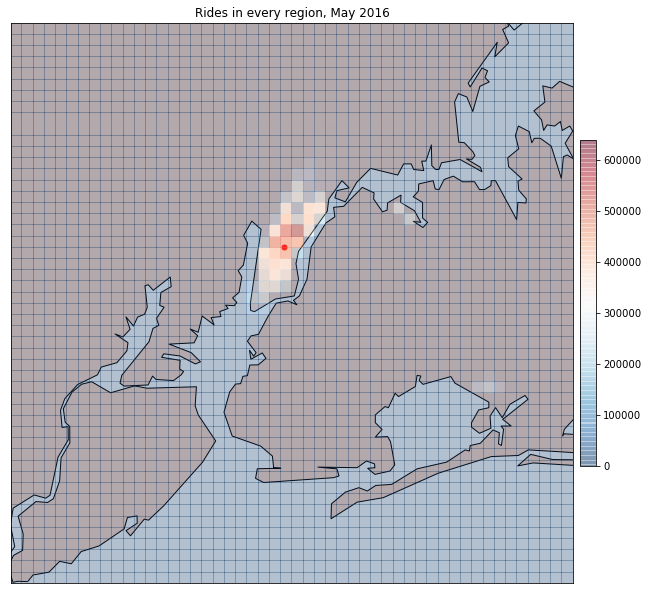

In [68]:
# Рисуем Empire State Building
plt.figure(figsize=(12,12))

m = Basemap(projection='merc',
            llcrnrlat=ymin,urcrnrlat=ymax,
            llcrnrlon=xmin,urcrnrlon=xmax,
            resolution='h')
m.drawcoastlines()
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')

location_esb = get_address("Empire State Building")
x_esb, y_esb = m(location_esb[1], location_esb[0])
m.plot(x_esb, y_esb, "bo", markersize=5, color='red', zorder=1)

# Рисуем общее число поездок из каждой ячейки за май месяц
x = np.linspace(m.llcrnrx, m.urcrnrx, 51)
y = np.linspace(m.llcrnry, m.urcrnry, 51)
xx, yy = np.meshgrid(x, y)
z = np.array(sum_rides).reshape(50,50).T
m.pcolormesh(xx, yy, z, alpha=0.3, shading='Flat', cmap='RdBu_r', zorder=2)

# шкала поездок
cbar = plt.colorbar(orientation='vertical',pad=0.01, shrink=0.5)

plt.title('Rides in every region, May 2016')